# Tutorial 3 - Boosting Search via Symmetry Breaking, Implied Constraints, Randomisation, and Restarts 
revisit the exact parameters so that restars work) 

**Please do not read untill you fully finish the first 2 tutorials**

Congratulations! you are now level one constraint programmer: you know the basics on how to model a problem, how to display solutions, how to evaluate models, and how to choose a good branching strategy !! **I'm so proud of you!**

In this tutorial we slowly dive into advanced techniques. We also start to use arithmetic constraints and solve optimisation problems.

In [1]:
from config import setup
setup()

## Golomb ruler

Your goal is to place $N$ marks on a ruler, such that no two marks are at the same distance and the total length of the ruler (the position of the last mark) is minimized. 

<div class="row" style="margin-top: 10px">
    <img src="display/images/Golomb_Ruler-4.svg" style="display: block; margin: auto; width: 400px;" />
    <p style="margin: auto; margin-top: 10px; text-align: center;">Golomb ruler of order 4 and length 6. This ruler is both optimal and perfect.</p>
</div>

Golomb ruler can be used in information theory to design error correcting codes or in telecommunications to avoid interferences during radio communications. You can read about it here https://en.wikipedia.org/wiki/Golomb_ruler#:~:targetText=In%20mathematics%2C%20a%20Golomb%20ruler,are%20the%20same%20distance%20apart.&targetText=It%20has%20been%20proven%20that,of%20the%20same%20order%20exists.


**In the rest of this tutorial (except the last part), please use the following parameter with the solve method:**

```
SearchType= 'DepthFirst'
```

Also, in order to control the level of filtering (arc consistency, bound consistency, forward checking, etc), CPoptimizer offers to use a parameter called $DefaultInferenceLevel$  http://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.parameters.py.html?highlight=defaultinferencelevel#docplex.cp.parameters.CpoParameters.DefaultInferenceLevel

In the rest of this tutorial, you are required to test all three possibilities


```
DefaultInferenceLevel=Low
DefaultInferenceLevel=Medium
DefaultInferenceLevel=Extended

```

After a while, if you see one that you particularly find efficient (runtime), you can use it for the rest of the tutorial. 


Create a model for the decision version of this problem. That is, given $n$ marks, and a ruler of size $m$, place the $n$ markers such that no two markers are at the same distance. 

You are free to use any constraint you want. However, you must declare and use the minimum amount of constraints (**NOT A SINGLE UNNESSASARY CONSTRAINT**)

Note that for N marks, a ruler of length $2 ^ {N -1}$ can be found (I let you figure out why). 

Write a funtion decision_model(n,m) that builds and returns the correspondant model. 

In [2]:
## install docplex first with $pip install docplex
from docplex.cp.model import *
from docplex.cp.config import get_default


In [3]:

def decision_model(n,m):
    mdl = CpoModel(name="GolombRuler")
    # Create array of variables corresponding to ruler marks
    ruler_marks = mdl.integer_var_list(n, 0, m, "marks")

    mdl.add(all_diff(ruler_marks))


    # Create an array with all distances between all marks
    diffs = []
    for i in range(n):
        for j in range(0,i):
            diffs.append(abs(ruler_marks[i]-ruler_marks[j]))
    #constraints
    mdl.add(all_diff(diffs))
    # mdl.add(mdl.minimize(marks[m - 1]))
    return mdl, ruler_marks

Solve the problem for n=4, m=6. Then try different values of (n,m) (but don't waste too much time). 

In [4]:
#Solve the problem for n = 4, m= 6
mdl, ruler_marks = decision_model(4,6)
print("Solving model....")
sol = mdl.solve(TimeLimit=100)

Solving model....
 ! --------------------------------------------------- CP Optimizer 22.1.0.0 --
 ! Satisfiability problem - 4 variables, 2 constraints
 ! Presolve             = Off
 ! TimeLimit            = 15
 ! Workers              = 1
 ! Initial process time : 0.19s (0.19s extraction + 0.00s propagation)
 !  . Log search space  : 11.2 (before), 11.2 (after)
 !  . Memory usage      : 267.0 kB (before), 267.0 kB (after)
 ! Using sequential search.
 ! ----------------------------------------------------------------------------
 !               Branches  Non-fixed            Branch decision
 *                      8  0.31s                  3 != marks_3
 ! ----------------------------------------------------------------------------
 ! Search completed, 1 solution found.
 ! ----------------------------------------------------------------------------
 ! Number of branches     : 8
 ! Number of fails        : 2
 ! Total memory usage     : 687.6 kB (647.9 kB CP Optimizer + 39.7 kB Concert)


In [5]:

# Use CpoSolveResult.print_solution to get an overview of the solution
# Print solution
print("Solution: ")
sol.write()

Solution: 
-------------------------------------------------------------------------------
Model constraints: 2, variables: integer: 4, interval: 0, sequence: 0
Solve status: Feasible
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.3 sec
-------------------------------------------------------------------------------
Variables:
   marks_0 = 6
   marks_1 = 5
   marks_2 = 0
   marks_3 = 2


You can display to solution using  :  

```
from display import golomb as display_golomb
display_golomb([sol[m] for m in marks])
```

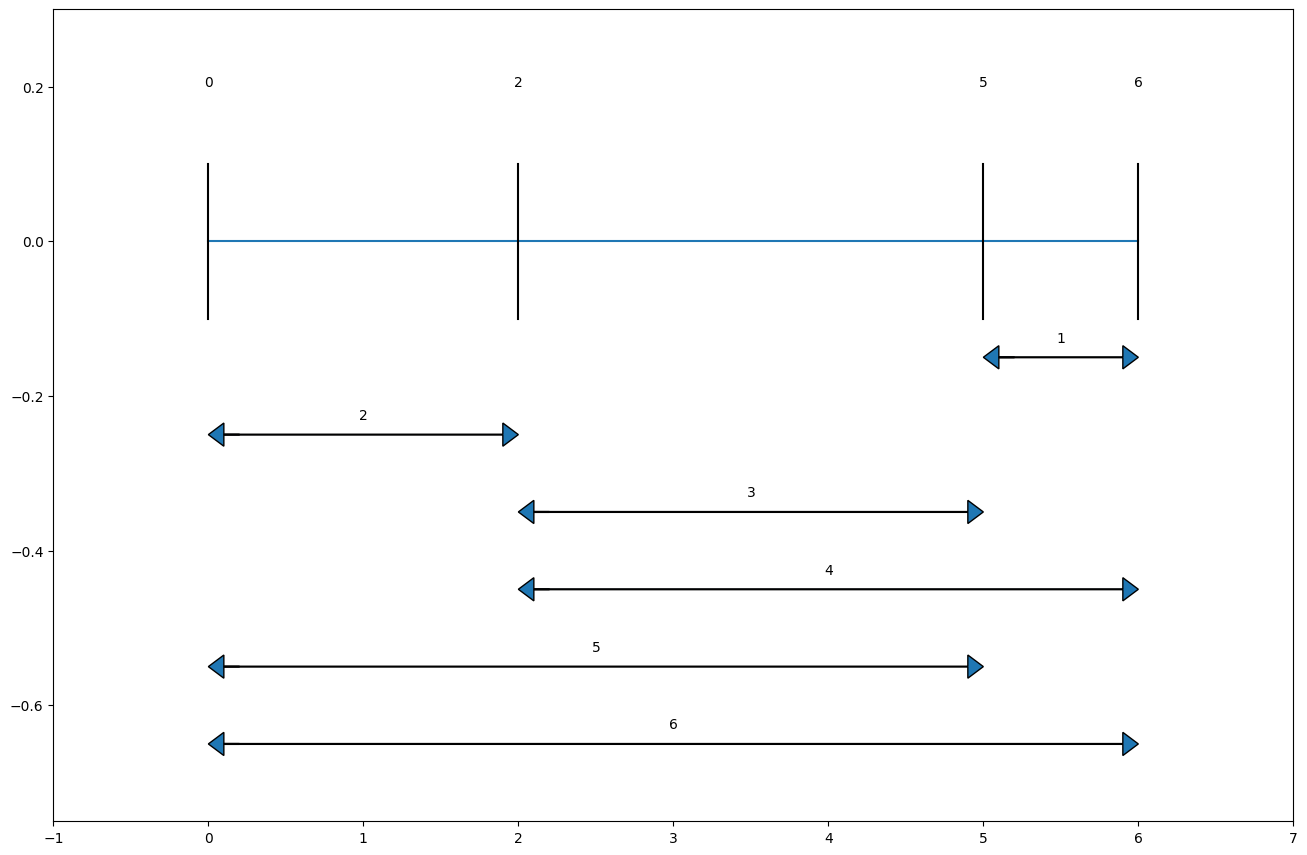

In [6]:
from display import golomb as display_golomb
import matplotlib.pyplot as plt

%matplotlib inline
m = 6
display_golomb([sol[m] for m in ruler_marks])

Print and display all the sulutions for (n,m) = (4,6) and (4,7)

In [7]:
def get_nb_solutions(list):
    cnt = 0
    for i in list:
        cnt += 1
    return cnt

In [8]:

n = 4
m = 7
mdl, _ = decision_model(n,m)
msol = mdl.start_search(SearchType="DepthFirst", LogVerbosity='Quiet')
#print the number of solutions in list_sol
print('n={} and m={}, {} solution(s) found.'.format(n, m, get_nb_solutions(msol)))

n=4 and m=7, 240 solution(s) found.


In [9]:
n = 4
m = 6
mdl, _ = decision_model(n,m)
msol = mdl.start_search(SearchType="DepthFirst", LogVerbosity='Quiet')
#print the number of solutions in list_sol
print('n={} and m={}, {} solution(s) found.'.format(n, m, get_nb_solutions(msol)))

n=4 and m=6, 48 solution(s) found.


Write a funtion  basic_optimisation_model(n) that builds and returns the correspondant model for the
optimisation problem. Note that an optimisation function can be seen as a variable. In order to specify the variable to optimise, we can simply use : 

```
model.add(model.minimize(myvariable))
```

or 

```
model.add(model.maximize(myvariable))
```


In [10]:
def basic_optimisation_model(n):
    mdl = CpoModel(name="GolombRuler")
    # Create array of variables corresponding to ruler marks
    ruler_marks = mdl.integer_var_list(n, 0, (n-1)**2, "marks")

    mdl.add(all_diff(ruler_marks))


    # Create an array with all distances between all marks
    diffs = []
    for i in range(n):
        for j in range(0,i):
            diffs.append(abs(ruler_marks[i]-ruler_marks[j]))
    #constraints
    mdl.add(all_diff(diffs))

    #mdl.add(mdl.minimize(ruler_marks[n-1]))
    mdl.add(mdl.minimize(mdl.max(diffs)))
    return mdl, ruler_marks

Solve the optimisation problem for N=6.. 10  and display the solution

In [11]:
mdl, _ = basic_optimisation_model(6)
print("Solving model....")
sol = mdl.solve(TimeLimit=100)

Solving model....
 ! --------------------------------------------------- CP Optimizer 22.1.0.0 --
 ! Minimization problem - 6 variables, 2 constraints
 ! Presolve             = Off
 ! TimeLimit            = 15
 ! Workers              = 1
 ! Initial process time : 0.03s (0.03s extraction + 0.00s propagation)
 !  . Log search space  : 28.2 (before), 28.2 (after)
 !  . Memory usage      : 299.5 kB (before), 299.5 kB (after)
 ! Using sequential search.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed            Branch decision
                        0          6                 -
 + New bound is 0
                        0          6                 -
 + New bound is 1
                       98          5        F    24 != marks_3
 + New bound is 2
 *            20      104  0.07s               (gap is 90.00%)
 *            19      159  0.07s               (gap is 89.47%)
 *            18      200  0.07s               (ga

In [12]:
# Use CpoSolveResult.print_solution to get an overview of the solution
# Print solution
print("Solution: ")
sol.write()

Solution: 
-------------------------------------------------------------------------------
Model constraints: 2, variables: integer: 6, interval: 0, sequence: 0
Solve status: Feasible
Search status: SearchStopped, stop cause: SearchStoppedByLimit
Solve time: 15 sec
-------------------------------------------------------------------------------
Objective values: (17,), bounds: (2,), gaps: (0.882353,)
Variables:
   marks_0 = 4
   marks_1 = 17
   marks_2 = 0
   marks_3 = 10
   marks_4 = 12
   marks_5 = 1


In [13]:
for n in range (6,11):
    mdl, _ = basic_optimisation_model(n)
    print("Solving model....")
    sol = mdl.solve(TimeLimit=100)
    print("Solution: ")
    sol.write()

Solving model....
 ! --------------------------------------------------- CP Optimizer 22.1.0.0 --
 ! Minimization problem - 6 variables, 2 constraints
 ! Presolve             = Off
 ! TimeLimit            = 15
 ! Workers              = 1
 ! Initial process time : 0.02s (0.02s extraction + 0.00s propagation)
 !  . Log search space  : 28.2 (before), 28.2 (after)
 !  . Memory usage      : 299.5 kB (before), 299.5 kB (after)
 ! Using sequential search.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed            Branch decision
                        0          6                 -
 + New bound is 0
                        0          6                 -
 + New bound is 1
                       98          5        F    24 != marks_3
 + New bound is 2
 *            20      104  0.02s               (gap is 90.00%)
 *            19      159  0.02s               (gap is 89.47%)
 *            18      200  0.02s               (ga

# Symmetry Breaking

In combinatorial optimisation, two (partial) solutions are called symmetric if we can find a transformation from one to the other. 
Consider our golomb ruler problem. Given any solution to the marks variables, if the first mark is not at index $0$, we can always shift everything to the left to start from $0$ and still have a solution. 

Constraint programming is extremely flexible to handle symmetries since they can be declared as constraints. 

In the case of the above symmetry, we can simply add 
```
model.add (marks[0]==0)
```

This problem has another symmetry, can you find it? In order to help you, display the solution for n=4 and m=6 for the decision problem. You should find 2 solutions that are essentially the same. Can you find the symmetry? How can we model this symmetry as a constraint? 

In [14]:
n = 4
m = 6
mdl, _ = decision_model(n,m)
msol = mdl.start_search(SearchType="DepthFirst", LogVerbosity='Quiet')
for i in msol:
    i.write()

#print the number of solutions in list_sol
print('n={} and m={}, {} solution(s) found.'.format(n, m, get_nb_solutions(msol)))

-------------------------------------------------------------------------------
Model constraints: 2, variables: integer: 4, interval: 0, sequence: 0
Solve status: Feasible
Search status: SearchOngoing, stop cause: SearchHasNotBeenStopped
Solve time: 0 sec
-------------------------------------------------------------------------------
Variables:
   marks_0 = 1
   marks_1 = 0
   marks_2 = 6
   marks_3 = 4
-------------------------------------------------------------------------------
Model constraints: 2, variables: integer: 4, interval: 0, sequence: 0
Solve status: Feasible
Search status: SearchOngoing, stop cause: SearchHasNotBeenStopped
Solve time: 0 sec
-------------------------------------------------------------------------------
Variables:
   marks_0 = 1
   marks_1 = 0
   marks_2 = 4
   marks_3 = 6
-------------------------------------------------------------------------------
Model constraints: 2, variables: integer: 4, interval: 0, sequence: 0
Solve status: Feasible
Search stat

Write a new function nosymmetry_optimisation_model(n) that builds a new model that avoids the two symmetries we found so far. 

In [15]:
def nosymmetry_optimisation_model(n):
    mdl = CpoModel(name="GolombRuler")
    # Create array of variables corresponding to ruler marks
    ruler_marks = mdl.integer_var_list(n, 0, (n-1)**2, "marks")

    mdl.add(all_diff(ruler_marks))


    # Create an array with all distances between all marks
    diffs = []
    for i in range(n):
        for j in range(0,i):
            diffs.append(abs(ruler_marks[i]-ruler_marks[j]))
    #constraints
    mdl.add(all_diff(diffs))
    #constraint of symmetry breaking
    # Force first mark position to zero
    mdl.add(ruler_marks[0] == 0)
    # Avoid symmetric solutions by ordering marks
    for i in range(1, n):
        mdl.add(ruler_marks[i] > ruler_marks[i - 1])
    # Avoid mirror solution
    mdl.add((ruler_marks[1] - ruler_marks[0]) < (ruler_marks[n - 1] - ruler_marks[n - 2]))

    # mdl.add(mdl.minimize(ruler_marks[n-1]))
    mdl.add(mdl.minimize(mdl.max(diffs)))
    return mdl, ruler_marks

In [32]:
mdl, _ = nosymmetry_optimisation_model(8)
print("Solving model....")
sol = mdl.solve(TimeLimit=100)
msol = mdl.start_search(SearchType="DepthFirst", LogVerbosity='Quiet')
j = 0
for i in msol:
    j += 1
    i.write()
print(j)

Solving model....
 ! --------------------------------------------------- CP Optimizer 22.1.0.0 --
 ! Minimization problem - 8 variables, 11 constraints
 ! Presolve             = Off
 ! TimeLimit            = 15
 ! Workers              = 1
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 45.2 (before), 45.2 (after)
 !  . Memory usage      : 300.0 kB (before), 300.0 kB (after)
 ! Using sequential search.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed            Branch decision
                        0          8                 -
 + New bound is 0
                        0          8                 -
 + New bound is 8
                        0          7                 -
 + New bound is 9
                        2          6        F     5 != marks_5
 + New bound is 10
 *            45       58  0.00s               (gap is 77.78%)
 *            44      400  0.00s      

Compare nosymmetry_optimisation_model and basic_optimisation_model for different values of $n$ (you decide the values of $n$). Plot the runtime and the search tree size

In [17]:
#Consider run(model, params) function for Tutorial1.ipynb copy and paste it here


def run(model, params):
    sol = model.solve(TimeLimit=params.TimeLimit, LogVerbosity = "Quiet")
    return sol.get_solver_infos()['NumberOfChoicePoints'], sol.get_solver_infos()['TotalTime'], sol.get_solve_status()

from docplex.cp.parameters import CpoParameters

params = CpoParameters(TimeLimit=100,  SearchType='DepthFirst')
        

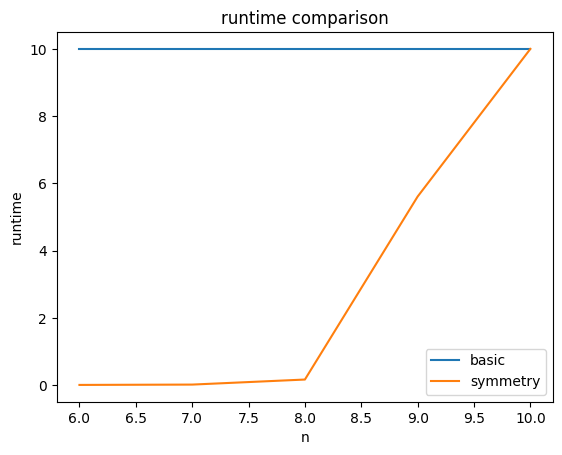

In [18]:
# Compare nosymmetry_optimisation_model with basic_optimisation_model for different values of n (plot the runtime)

import matplotlib.pyplot as plt
%matplotlib inline
N=[i for i in range(6,11)]
y_basic=[]
y_symmetry=[]
for n in range (6,11):
    basic, _ = basic_optimisation_model(n)
    symmetry, _ = nosymmetry_optimisation_model(n)
    y_basic.append(run(basic, params)[1])
    y_symmetry.append(run(symmetry, params)[1])

plt.plot(N, y_basic, label='basic')
plt.plot(N, y_symmetry, label='symmetry')
plt.xlabel('n')
plt.ylabel('runtime')
plt.title('runtime comparison')
plt.legend()
plt.show()


What's your impression about symmetries? 

## Implied Constraints

An implied constraint is one that can be dedused by looking at the original constraints of the problem. 

For instance, if we have $a<b $ and $b<c$, one can infer that $a<c$. 

Such constraints (called also redundant constraints) can help the solver to prune further the search tree. 



In our problem there is an implied constraint. Can you find it? Please check with of the supervisors. 



Write a new function nosymmetry2_optimisation_model(n) that adds the implied constraint to the nosymmetry_optimisation_model(n) and returns the new model 

In [25]:
#Write nosymmetry2_optimisation_model(n) that adds the implied constraint the function and returns the new model

def nosymmetry2_optimisation_model(n):
    mdl = CpoModel(name="GolombRuler")
    # Create array of variables corresponding to ruler marks
    ruler_marks = mdl.integer_var_list(n, 0, (n-1)**2, "marks")

    mdl.add(all_diff(ruler_marks))


    # Create an array with all distances between all marks
    diffs = []
    for i in range(n):
        for j in range(0,i):
            diffs.append(abs(ruler_marks[i]-ruler_marks[j]))
    #constraints
    mdl.add(all_diff(diffs))
    #constraint of symmetry breaking
    # Force first mark position to zero
    mdl.add(ruler_marks[0] == 0)
    # Avoid symmetric solutions by ordering marks
    for i in range(1, n):
        mdl.add(ruler_marks[i] > ruler_marks[i - 1])
        
    # Avoid mirror solution
    mdl.add((ruler_marks[1] - ruler_marks[0]) < (ruler_marks[n - 1] - ruler_marks[n - 2]))
    #implied constraint
    mdl.add(mdl.minimize(mdl.max(diffs)))
    return mdl, ruler_marks

Compare nosymmetry2_optimisation_model and nosymmetry_optimisation_model 

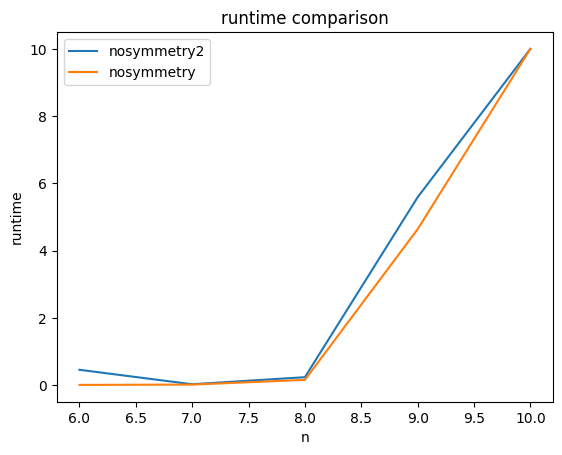

In [26]:
# Compare nosymmetry_optimisation_model with basic_optimisation_model for different values of n (plot the runtime)

import matplotlib.pyplot as plt
%matplotlib inline
N=[i for i in range(6,11)]
y_nosymmetry2=[]
y_nosymmetry=[]
for n in range (6,11):
    nosymmetry2, _ = nosymmetry2_optimisation_model(n)
    nosymmetry, _ = nosymmetry_optimisation_model(n)
    y_nosymmetry2.append(run(nosymmetry2, params)[1])
    y_nosymmetry.append(run(nosymmetry, params)[1])

plt.plot(N, y_nosymmetry2, label='nosymmetry2')
plt.plot(N, y_nosymmetry, label='nosymmetry')
plt.xlabel('n')
plt.ylabel('runtime')
plt.title('runtime comparison')
plt.legend()
plt.show()


# Randomisation and Restarts

Declare two search strategies: One that uses a lexicographical order on both variables and values, 
    and the other using an impact-based choice on the variables with a random value selection.     

Run the two strategies using the nosymmetry2_optimisation_model for different values of $n$

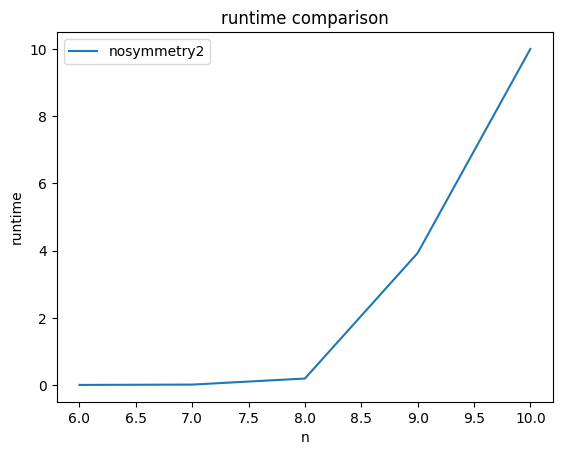

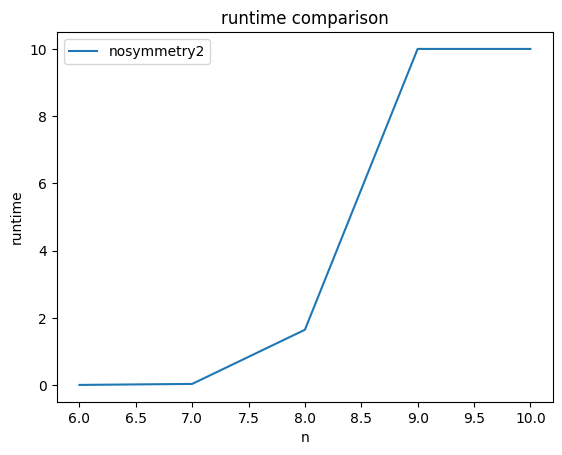

In [60]:
# # Declare a search strategy using the nosymmetry2_optimisation for different values of n : 1/ lexicographical order on both variables and values
N=[i for i in range(6,11)]
y = []
for n in N:
    nosymmetry2, ss = nosymmetry2_optimisation_model(n)

    #Create SearchPhase
    SearchPhase = nosymmetry2.search_phase(ss, 
                                            varchooser=nosymmetry2.select_smallest(nosymmetry2.var_index(ss)),
                                            valuechooser=nosymmetry2.select_smallest(nosymmetry2.value_index([i for i in range(n)])))
    nosymmetry2.add_search_phase(SearchPhase)
    y.append(run(nosymmetry2, params)[1])


plt.plot(N, y, label='nosymmetry2')
plt.xlabel('n')
plt.ylabel('runtime')
plt.title('runtime comparison')
plt.legend()
plt.show()

# Declare a search strategy with a random value selection
N=[i for i in range(6,11)]
y = []
for n in N:
    nosymmetry2, ss = nosymmetry2_optimisation_model(n)

    #Create SearchPhase
    SearchPhase = nosymmetry2.search_phase(ss, 
                                            varchooser=nosymmetry2.select_smallest(nosymmetry2.var_impact()),
                                            valuechooser=nosymmetry2.select_random_value())
    nosymmetry2.add_search_phase(SearchPhase)
    y.append(run(nosymmetry2, params)[1])

plt.plot(N, y, label='nosymmetry2')
plt.xlabel('n')
plt.ylabel('runtime')
plt.title('runtime comparison')
plt.legend()
plt.show()

### The magic of restarts


Combinatorial search exhibits usually a bad behaviour in the runtime distribution called **heavy tailed phenomenon**. 
That is, at any node of the search tree, there is a non-negligeable probability that the time needed to explore the current subtree is heavier than 
an exponential distribution (you can read about it here https://aaai.org/Papers/AAAI/1998/AAAI98-061.pdf. 


A simple solution to deal with such a bad behaviour is to restart search from time to time. 
CPOptimizer offers this choice by using the parameter: 
    
```
    SearchType= 'Restart'
```



Using a restart search, evaluate the two strategies mentionned above using the nosymmetry2_optimisation_model for different values of $n$. What do you think?  

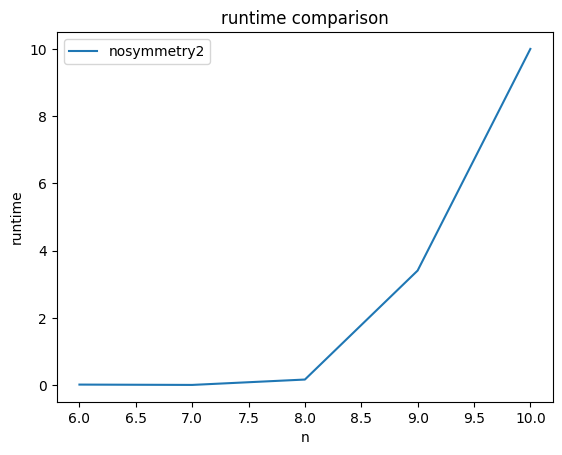

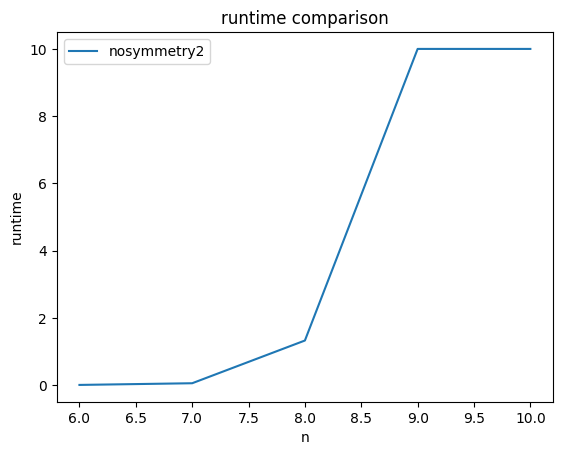

In [61]:
#Use a restart search with SearchType= 'Restart', evaluate the two strategies mentionned above for different values of n

params = CpoParameters(TimeLimit=100,  SearchType='Restart')


N=[i for i in range(6,11)]
y = []
for n in N:
    nosymmetry2, ss = nosymmetry2_optimisation_model(n)

    #Create SearchPhase
    SearchPhase = nosymmetry2.search_phase(ss, 
                                            varchooser=nosymmetry2.select_smallest(nosymmetry2.var_index(ss)),
                                            valuechooser=nosymmetry2.select_smallest(nosymmetry2.value_index([i for i in range(n)])))
    nosymmetry2.add_search_phase(SearchPhase)
    y.append(run(nosymmetry2, params)[1])
plt.plot(N, y, label='nosymmetry2')
plt.xlabel('n')
plt.ylabel('runtime')
plt.title('runtime comparison')
plt.legend()
plt.show()

y = []
for n in N:
    nosymmetry2, ss = nosymmetry2_optimisation_model(n)

    #Create SearchPhase
    SearchPhase = nosymmetry2.search_phase(ss, 
                                            varchooser=nosymmetry2.select_smallest(nosymmetry2.var_impact()),
                                            valuechooser=nosymmetry2.select_random_value())
    nosymmetry2.add_search_phase(SearchPhase)
    y.append(run(nosymmetry2, params)[1])

plt.plot(N, y, label='nosymmetry2')
plt.xlabel('n')
plt.ylabel('runtime')
plt.title('runtime comparison')
plt.legend()
plt.show()

What is the maximum value of $n$ for which you can solve this problem? Use all your techniques! 

In [71]:
### WARNING : This block takes a lot of time to execute
# A lot of configurations try for instance 

# What is the maximum value of n for which you can solve this problem ?

j=3
while j < 10000:
    j+=1
    nosymmetry2, ss = nosymmetry2_optimisation_model(j)

    #Create SearchPhase
    SearchPhase = nosymmetry2.search_phase(ss, 
                                            varchooser=nosymmetry2.select_smallest(nosymmetry2.var_impact()),
                                            valuechooser=nosymmetry2.select_random_value())
    nosymmetry2.add_search_phase(SearchPhase)
    runtime = run(nosymmetry2, params)[1]
    status = run(nosymmetry2, params)[2]
    print(status)
    print(j)

Optimal
4
Optimal
5
Optimal
6
Optimal
7
Optimal
8
Feasible
9
Feasible
10
Feasible
11
Feasible
12
Feasible
13
Unknown
14
Unknown
15
Unknown
16
Unknown
17


KeyboardInterrupt: 

What did you learn today? 